# Linear regression - OLS Model

In this section, we will cover:

- fitting an OLS linear regression model
- score analysis: MSE and variance explained: $R^2$
- residual analysis

In [1]:
import pandas as pd
import numpy as np
import pickle
import time

In [2]:
df = pd.read_csv('data/df_resample.csv')
df.head()

,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,0,nissan,gas,std,four,sedan,fwd,front,97.2,173.4,...,120,2bbl,3.33,3.47,8.5,97.0,5200.0,27,34,9549.0
1,3,volkswagen,gas,std,two,hatchback,fwd,front,94.5,165.7,...,109,mpfi,3.19,3.40,8.5,90.0,5500.0,24,29,9980.0
2,1,bmw,gas,std,four,sedan,rwd,front,103.5,189.0,...,164,mpfi,3.31,3.19,9.0,121.0,4250.0,20,25,24565.0
3,2,subaru,gas,std,two,hatchback,fwd,front,93.7,156.9,...,97,2bbl,3.62,2.36,9.0,69.0,4900.0,31,36,5118.0
4,0,mazda,diesel,std,four,sedan,rwd,front,104.9,175.0,...,134,idi,3.43,3.64,22.0,72.0,4200.0,31,39,18344.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          10000 non-null  int64  
 1   make               10000 non-null  object 
 2   fuel_type          10000 non-null  object 
 3   aspiration         10000 non-null  object 
 4   num_of_doors       10000 non-null  object 
 5   body_style         10000 non-null  object 
 6   drive_wheels       10000 non-null  object 
 7   engine_location    10000 non-null  object 
 8   wheel_base         10000 non-null  float64
 9   length             10000 non-null  float64
 10  width              10000 non-null  float64
 11  height             10000 non-null  float64
 12  curb_weight        10000 non-null  int64  
 13  engine_type        10000 non-null  object 
 14  num_of_cylinders   10000 non-null  object 
 15  engine_size        10000 non-null  int64  
 16  fuel_system        1000

## Train-test split

To avoid overfitting, we will split our data on train and test sets.

The model will be trained with the train dataset and later we will evaluate it with the test set.


In [4]:
from sklearn.model_selection import train_test_split

X = df.copy()
X.drop('price', axis=1, inplace=True)
y = np.log(df.price) # as discussed, we are going to use the log transformation here

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.3, random_state=95276
)

## Feature Selection

It is very important to carefully chose which features will be included into the model, because:

- including unnecessary features increases the standard error of the coefficients
- excluding necessary features results in bias

### Selection through correlation

As we want start trying out linear regression models, we will select features that have linear correlation with the dependent variable price.


In [5]:
# categorical features
with open('data/category_list', 'rb') as file:
    cat_cols = pickle.load(file)

# numeric columns
num_cols = [col for col in X_train.columns if col not in cat_cols]
num_cols

['wheel_base',
 'length',
 'width',
 'height',
 'curb_weight',
 'engine_size',
 'bore',
 'stroke',
 'compression_ratio',
 'horsepower',
 'peak_rpm',
 'city_mpg',
 'highway_mpg']

In [6]:
X_train['price'] = y_train
cols = num_cols + ['price']
cor = X_train[cols].corr().abs()
cor.loc[cor.price > .5, 'price'].sort_values()

C:\Users\BJ571WQ\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


bore           0.590618
wheel_base     0.637270
length         0.780432
city_mpg       0.785230
highway_mpg    0.788294
width          0.803110
horsepower     0.827188
engine_size    0.844736
curb_weight    0.895085
price          1.000000
Name: price, dtype: float64

In [7]:
mask = (cor.price > .5 ) & (cor.price < 1)
correlated = cor[mask].sort_values(by='price').index
not_correlated = [col for col in num_cols if col not in correlated]

print('correlated: ', correlated)
print('not correlated: ', not_correlated)

correlated:  Index(['bore', 'wheel_base', 'length', 'city_mpg', 'highway_mpg', 'width',
       'horsepower', 'engine_size', 'curb_weight'],
      dtype='object')
not correlated:  ['height', 'stroke', 'compression_ratio', 'peak_rpm']


## Fitting the model
### Formula for OLS

In [8]:
cat_list = [f'C({cat})' for cat in cat_cols]
cat_formula = ' + '.join(cat_list)
num_formula = ' + '.join(correlated)

formula = f'price ~ {cat_formula} + {num_formula}'
formula

'price ~ C(make) + C(fuel_type) + C(aspiration) + C(num_of_doors) + C(body_style) + C(drive_wheels) + C(engine_location) + C(engine_type) + C(num_of_cylinders) + C(fuel_system) + C(symboling) + bore + wheel_base + length + city_mpg + highway_mpg + width + horsepower + engine_size + curb_weight'

In [9]:
import statsmodels.formula.api as smf

model = smf.ols(formula=formula, data=X_train)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     3976.
Date:                Tue, 08 Sep 2020   Prob (F-statistic):               0.00
Time:                        16:41:56   Log-Likelihood:                 7096.2
No. Observations:                7000   AIC:                        -1.408e+04
Df Residuals:                    6944   BIC:                        -1.370e+04
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

## More feature selection: p-values

When we fit a linear regression model, we have to test the hypothesis that the evaluated coefficient for a given regressor is actually zero, meaning we don't need that regressor at all.

In other words, we have:

- $H_0$: the coefficient is zero
- $H_1$: the coefficient is not zero

Therefore, let's look into the p-values for each coefficient for each regressor to understand if they should be zero:

*if a p-value of a given coefficient is larger than 5%, then we fail to reject the null hypothesis that the coefficient actually is zero*

In [10]:
res.pvalues[res.pvalues > .05]
# we are not taking out make just because a few rotten apples

C(make)[T.mazda]                 0.932911
C(make)[T.mercedes-benz]         0.346465
C(make)[T.nissan]                0.288217
C(make)[T.volkswagen]            0.286270
C(num_of_cylinders)[T.twelve]    0.071427
C(symboling)[T.2]                0.998247
horsepower                       0.375116
dtype: float64


As we can see, the p-values for some makers are larger than 5%. We are not removing this feature.

On the other hand, hypothesis testing for variable horsepower coefficient shows it could be zero.

Therefore, lets remove this feature and fit the model again:

In [11]:
correlated = correlated.tolist()
correlated.remove('horsepower')
num_formula = ' + '.join(correlated)

formula = f'price ~ {cat_formula} + {num_formula}'

start = time.time()
model = smf.ols(formula=formula, data=X_train)
res = model.fit()
stop = time.time()
elapsed = stop - start

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     4050.
Date:                Tue, 08 Sep 2020   Prob (F-statistic):               0.00
Time:                        16:41:57   Log-Likelihood:                 7095.8
No. Observations:                7000   AIC:                        -1.408e+04
Df Residuals:                    6945   BIC:                        -1.370e+04
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [12]:
res.pvalues[res.pvalues > .05]

C(make)[T.mazda]            0.820602
C(make)[T.mercedes-benz]    0.327119
C(make)[T.nissan]           0.385010
C(make)[T.volkswagen]       0.216545
C(symboling)[T.2]           0.857865
dtype: float64

Now we are done with feature selection.

## Model Scoring & Evaluation

In [13]:
r2 = res.rsquared_adj

predictions = np.exp(res.predict(X_test)) # back transformation
mse = np.mean(
    (predictions - np.exp(y_test))**2
)

print(f'R^2: {r2:.4}')
print(f'MSE: {mse:.4}')

R^2: 0.969
MSE: 2.175e+06


In [14]:
data = {
    'model name': ['ols'],
    'r2': [r2],
    'MSE': [mse],
    'time': elapsed
       }

score_df = pd.DataFrame(data)
score_df.to_csv('data/scores.csv', index=False)
score_df

,model name,r2,MSE,time
0,ols,0.968982,2.175057e+06,0.363137




## Residual analysis

In a good model, we should expect that the residuals:

- have mean zero
- to be homoscedastic
- to be normal
- to have no correlation with the fitted values
- to have no correlation with any of the features

### Residual mean

In [15]:
res.resid.mean() # good!

-2.431832513138943e-15

### Residuals vs fitted values

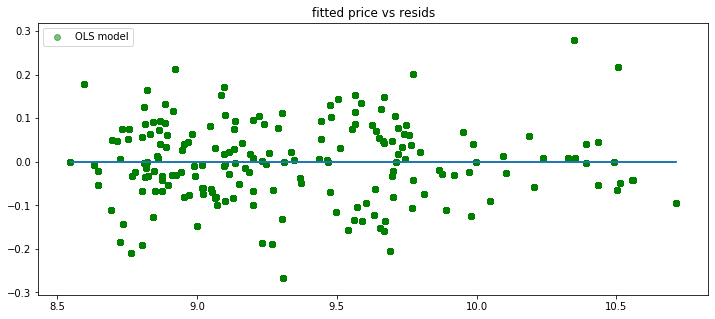

In [16]:
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(12, 5))
plt.title('fitted price vs resids')
plt.scatter(res.fittedvalues, res.resid, c="g", alpha=0.5, label="OLS model")
b, m = polyfit(res.fittedvalues, res.resid, 1)
plt.plot(res.fittedvalues, b + m * res.fittedvalues, '-')
plt.xlabel("")
plt.ylabel("")
plt.legend(loc=2)

### Correlation between residuals and $\hat y$

In a good model, residuals cannot be correlated to the fitted values. 

In [17]:
from scipy.stats.stats import pearsonr
pearsonr(res.predict(X_train), res.resid)

(8.134968393358477e-13, 0.9999999999497379)

### Test for normality

In [18]:
import scipy.stats as st
st.shapiro(res.resid)

C:\Users\BJ571WQ\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.9971299767494202, 2.398374832068839e-10)

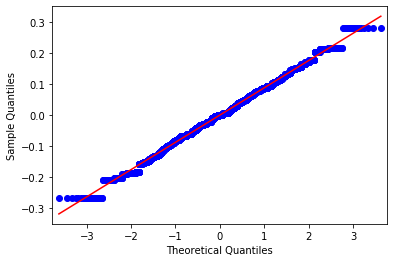

In [19]:
from statsmodels.graphics.gofplots import qqplot

qqplot(res.resid, line='s');